# Non-Ergodic GMM Regression (Type-2) using INLA
## Spatially Uncorrelated Anelastic Attenuation Cells

This notebook is used to estimate the non-ergodic coefficients, anelastic attenuation coefficients, and hyper-parameters of a type-2 non-ergodic GMM though Gaussian Process regression using the Bayesian software INLA. 

The Type-2 GMM compnents, with uncorrelated anelastic attenuation cells, are:
- The non-ergodic effects are modeled by:
  - $\delta c_{0}$:    constant shift of non-ergodic GMM with respect to base ergodic GMM
  - $\delta c_{1,E}$:  spatially varying eathquake adjustment as a function of the earthquake coordinates
  - $\delta c_{1a,S}$: spatially varying site adjustment as a function of the site coordinates
  - $\delta c_{1b,S}$: spatially independent site adjustment as a function of the station id
  - $c_{ca,P}$:        cell-specific anelastic attenuation
- The aleatory variability is captured by:
  - $\delta B^0_{e}$: between-event aleatory term
  - $\delta W^0_{e,s}$: within-event aleatory term
- The non-ergodic hyperparameters are:
  - $\ell_{1,E}$:     correlation lenght of spatially varying earthquake adjustment
  - $\ell_{1a,S}$:    correlation lenght of spatially varying site adjustment
  - $\omega_{1,E}$:   scale of spatially varying earthquake adjustment 
  - $\omega_{1a,S}$:  scale of spatially varying site adjustment
  - $\omega_{1b,S}$:  scale of spatially independent site adjustment
  - $\omega_{ca,P}$:  scale of anelastic attenuation cell coefficients
  - $\mu_{ca,P}$:     mean of cell-specific anelastic attenuation   
  - $\tau_{0}$:       standard deviation of between-event aleatory
  - $\phi_{0}$:       standard deviation of within-event aleatory

**Disclaimer:** The non-ergodic regression is perfomed on the total residuals (column ``res_name``) of a base ergodic GMM without including the effect of anelastic attenuation. 
The total regression residuals ($\epsilon_{tot}$) without the effect of anelastic attenuation are defined as:
$$
\epsilon_{tot} = log(IM) - ((\mu_{erg}(M,R_{rup},V_{S30}, ...) - c_{a~erg} ~ R_{rup})
$$
where $IM$ is the intesity parameter of interest (e.g. PGA, PSA), $\mu_{erg}$ is mean functional form of the ergodic GMM in log space, and $c_{a~erg}$ is the ergodic anelastic attenuation coefficient.


This script was developed as part of the Non-ergodic Methodology and Modeling Tools research project summarized in the report by Lavrentiadis G., Kuehn N., Bozorgnia Y., Seylabi E., Meng X., Goulet C., and Kottke A. (2022), "Non‐ergodic Methodology and Modeling Tools (Report GIRS-2022-04)." Natural Hazards Risk and Resiliency Research Center, University of California, Los Angeles.

Support provided by the California Department of Transportation (Caltrans) and Pacific Gas and Electric Company (PG&E). 

## Load required functions

In [1]:
#user functions
source('../R_lib/regression/inla/regression_inla_model2_uncorr_cells_unbounded_hyp.R')

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-32, (SVN revision 1176)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /home/glavrent/anaconda3/envs/python_3.8stan/share/proj
Linking to sp version:1.5-0
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.

Loading required package: spam

Spam version 2.9-0 (2022-07-11) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name,

## User Input, Definition of Regression Parameters 
The 1st synthetic dataset based the NGAWest3 CA metadata for the type-2 NGMM is used as an example.
The user should update the variables in this section to point to the regression dataset of interest.

In [2]:
#regression name
reg_name  <- 'example_regression_ds2_inla'

#regression dataset
flatfile_fname <- '../../Data/Flatfiles/examp_datasets/CatalogNGAWest3CALite_synthetic_data_ngmm2_small_corr_len_Y1.csv'
#cell-path info and distance matrix
cellinfo_fname <- '../../Data/Flatfiles/examp_datasets/CatalogNGAWest3CALite_cellinfo.csv'
celldist_fname <- '../../Data/Flatfiles/examp_datasets/CatalogNGAWest3CALite_distancematrix.csv'

#output directory
dir_out <- '../../Data/Regression/example_ds2_inla/'

#INLA regression parameters
runinla_flag <- TRUE # TRUE or FALSE
res_name     <- 'tot'

#mesh coarseness
# #fine
# mesh_edge_max     <- 5
# mesh_inner_offset <- 15
# mesh_outer_offset <- 15
# #medium
# mesh_edge_max     <- 15
# mesh_inner_offset <- 15
# mesh_outer_offset <- 50
#coarse
mesh_edge_max     <- 50
mesh_inner_offset <- 50
mesh_outer_offset <- 150

#ergodic coefficients
c_a_erg <- 0.0 #anelastic attenuation

#approximation options
# if flag_gp_approx=TRUE uses int.strategy="eb" and strategy="gaussian"
# int.strategy="eb" corresponds to one integration point, and 
# strategy="gaussian" approximates posteriors as gaussian distributions
flag_gp_approx <- TRUE # TRUE or FALSE

#number of threads
# reduce number of threads if running out of memmory, if not specified
# number of CPU threads is used
n_threads <- 4

## Load Files

In [3]:
#load flatfile
df_flatfile  <- read.csv(flatfile_fname)

#load cell dataframes
df_cellinfo  <- read.csv(cellinfo_fname)
df_celldist  <- read.csv(celldist_fname)

## Preprocessing 
This section can be used by the user for any pre-porcessing steps of the regression dataset.

## Run Regression

In [4]:
print(paste("Running regression for: ",reg_name))

#run time start
run_t_strt <- Sys.time()

#run INLA model
RunINLA(df_flatfile, df_cellinfo, df_celldist, reg_name, dir_out, res_name=res_name, 
        c_a_erg=c_a_erg,
        runinla_flag=runinla_flag,
        mesh_edge_max=mesh_edge_max, 
        mesh_inner_offset=mesh_inner_offset, mesh_outer_offset=mesh_outer_offset,
        flag_gp_approx=flag_gp_approx,
        n_threads=n_threads)

#run time end
run_t_end <- Sys.time()

#compute run time
run_tm <- run_t_end - run_t_strt

#log run time
df_run_info <- data.frame(computer_name=Sys.info()["nodename"], reg_name=reg_name, run_time=run_tm)

#write out run info
write.csv(df_run_info, sprintf('%s/run_info.csv', dir_out), row.names=FALSE)

print(paste("Completed regression for: ",reg_name))

[1] "Running regression for:  example_regression_ds2_inla"
[1] "max R_rup misfit 1.76214598468505e-12"


Warning message in inla.model.properties.generic(inla.trim.family(model), mm[names(mm) == :
“Model 'z' in section 'latent' is marked as 'experimental'; changes may appear at any time.
  Use this model with extra care!!! Further warnings are disabled.”
Warning message in `[<-.data.frame`(`*tmp*`, "dc_0", , value = structure(list(mean = -0.037359591777166, :
“provided 7 variables to replace 6 variables”
Warning message in `[<-.data.frame`(`*tmp*`, "mu_cap", , value = structure(list(:
“provided 7 variables to replace 6 variables”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] NA

[1] "Completed regression for:  example_regression_ds2_inla"


## Regression Review
The next code chunks produce summary plots to review the regression fit.

In [5]:
#load non-ergodic coefficients, residuals, and cell specific anelastic attenuation
fname_hparam  <- file.path(dir_out, paste0(reg_name,'_inla_hyperparameters.csv'))
fname_gmotion <- file.path(dir_out, paste0(reg_name,'_inla_residuals.csv'))
fname_coeff   <- file.path(dir_out, paste0(reg_name,'_inla_coefficients.csv'))
fname_atten   <- file.path(dir_out, paste0(reg_name,'_inla_catten.csv'))
df_hparam  <- read.csv(fname_hparam, row.names=1)
df_gmotion <- read.csv(fname_gmotion)
df_coeff   <- read.csv(fname_coeff)
df_atten   <- read.csv(fname_atten)

#merge gm-flatfile with non-ergodic coeffs and res 
df_gmotion <- merge(df_flatfile,df_gmotion)
df_coeff   <- merge(df_flatfile,df_coeff)
#merge cell atten coeffs with cell atten info
df_atten   <- merge(df_cellinfo, df_atten)

#print mean and standard deviations of aleatory terms
fprintf('Between-event mean:\t %.3f\n', mean(df_gmotion$res_between))
fprintf('Within-event mean:\t %.3f\n',  mean(df_gmotion$res_within))
fprintf('Between-event std:\t %.3f\n',  sd(df_gmotion$res_between))
fprintf('Within-event std:\t %.3f\n',   sd(df_gmotion$res_within))

Between-event mean:	 -0.002
Within-event mean:	 -0.000
Between-event std:	 0.309
Within-event std:	 0.395


### Non-ergodic residuals

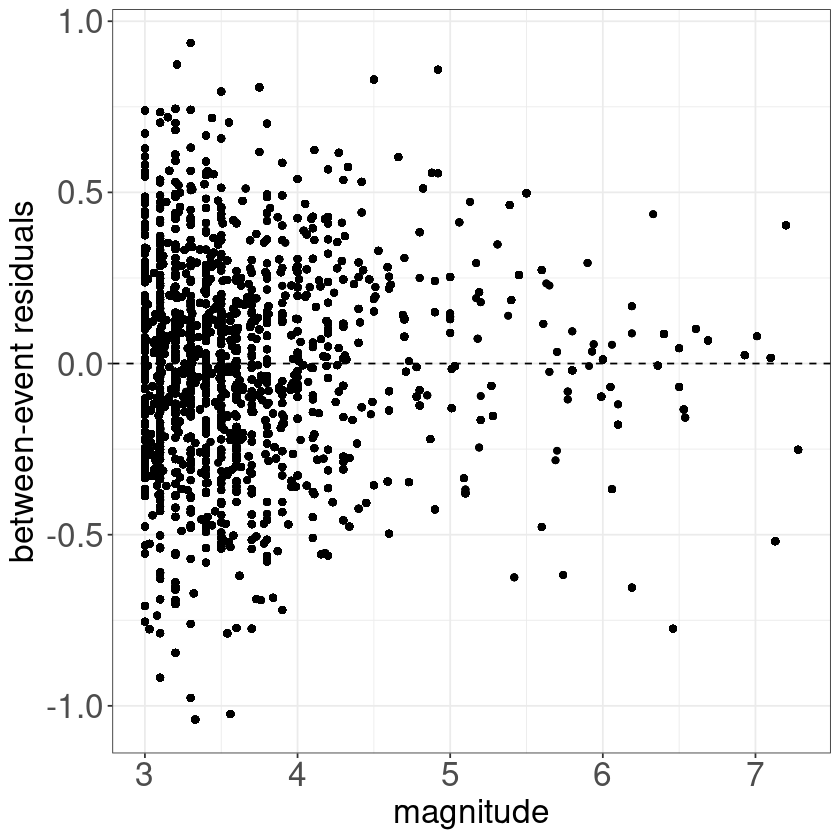

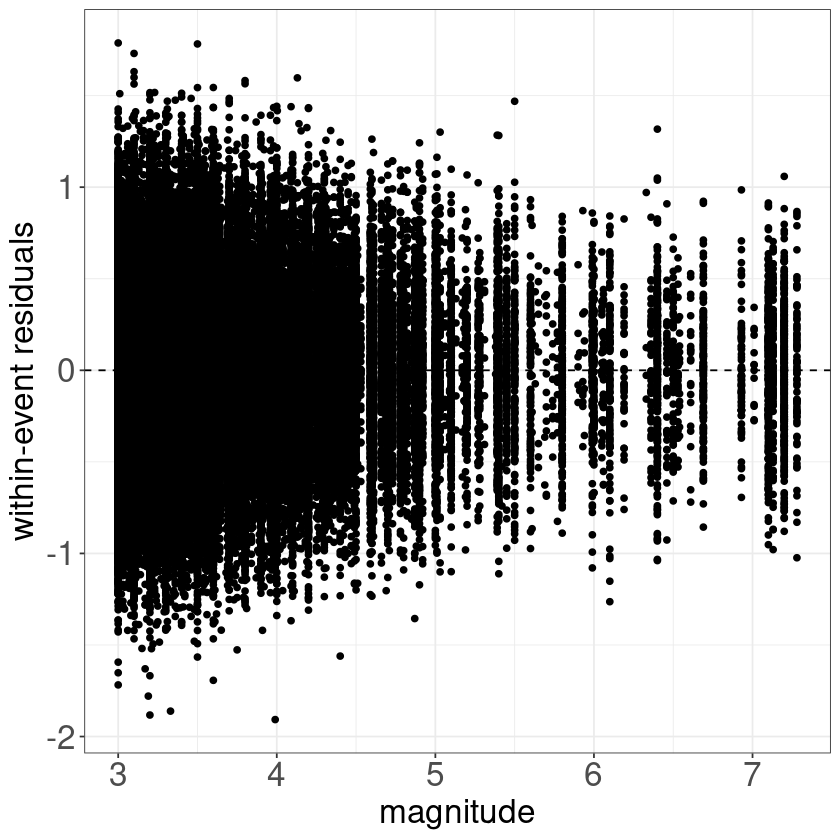

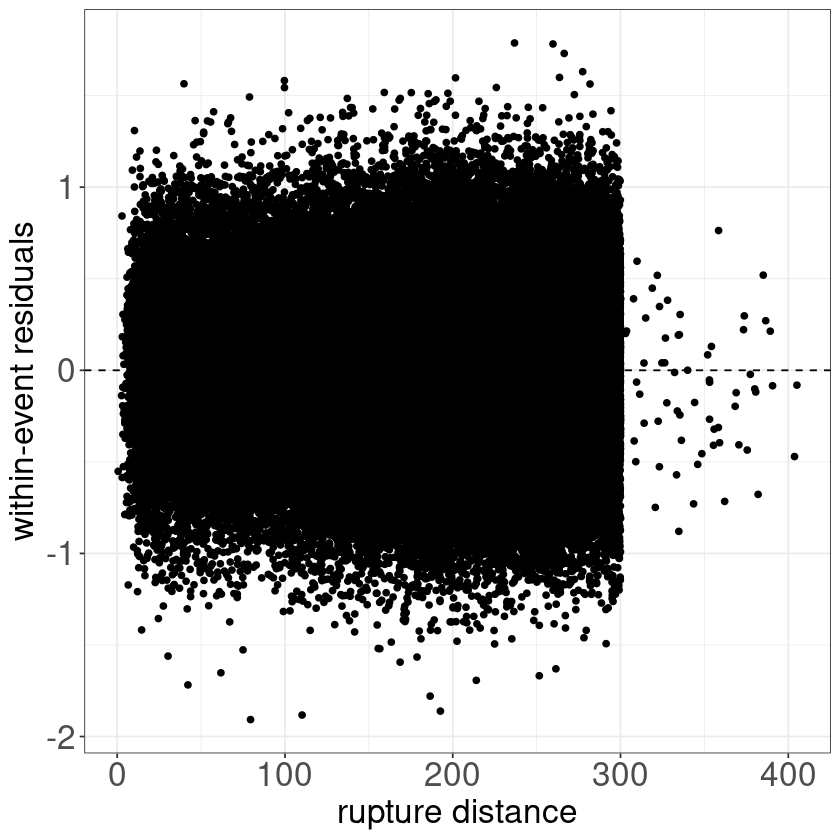

In [6]:
#between-event residuals 
pl_dB_mag <- ggplot(df_gmotion, aes(mag, res_between)) + theme_bw() +
              geom_point() + geom_hline(yintercept=0,linetype="dashed") +
              labs(x='magnitude', y='between-event residuals') + 
              theme(axis.title = element_text(size=20), 
                    axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#within-event residuals 
pl_dW_mag <- ggplot(df_gmotion, aes(mag, res_within)) + theme_bw() +
              geom_point() + geom_hline(yintercept=0,linetype="dashed") +
              labs(x='magnitude', y='within-event residuals') + 
              theme(axis.title = element_text(size=20), 
                    axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

pl_dW_Rrup <- ggplot(df_gmotion, aes(Rrup, res_within)) + theme_bw() +
               geom_point() + geom_hline(yintercept=0,linetype="dashed") +
               labs(x='rupture distance', y='within-event residuals') + 
               theme(axis.title = element_text(size=20), 
                     axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

print(pl_dB_mag)
print(pl_dW_mag)
print(pl_dW_Rrup)

### Non-ergodic Coefficients

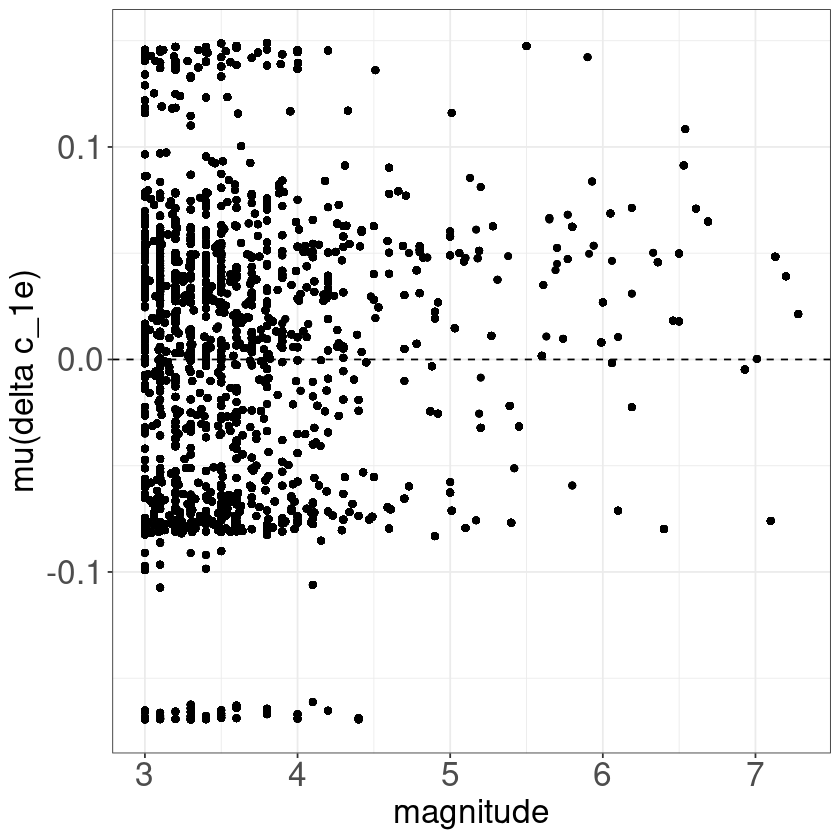

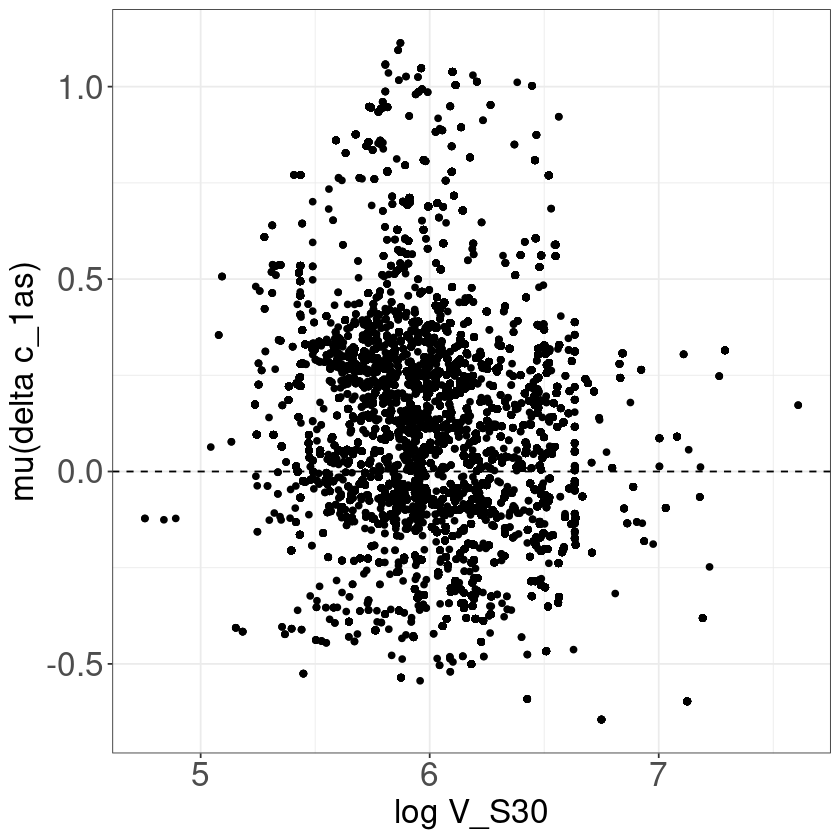

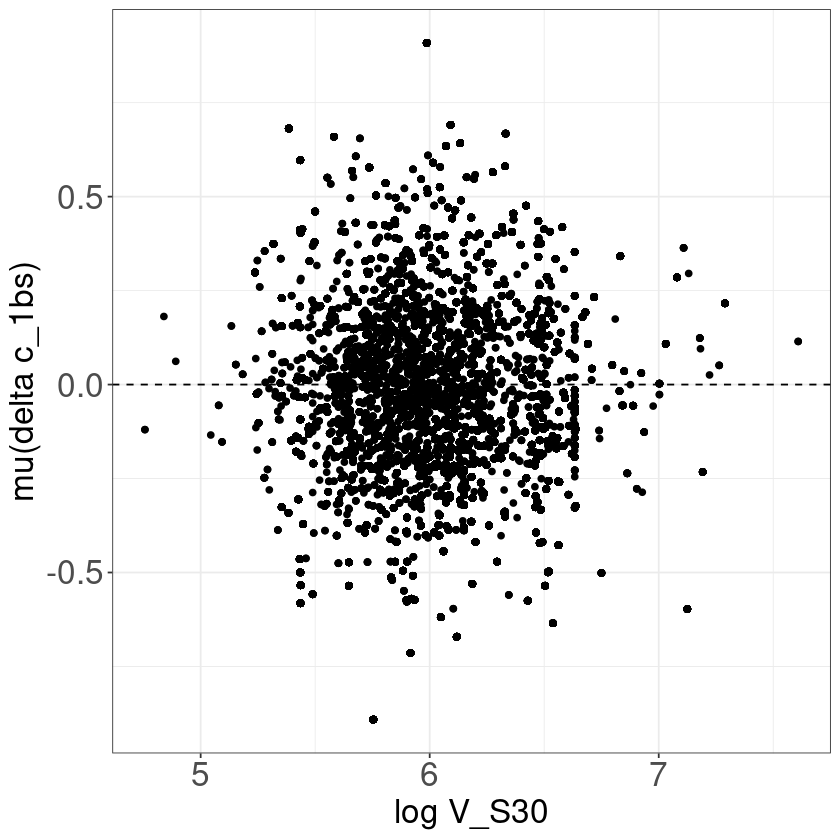

In [7]:
#spatially varying earthquake adjustment
pl_dc1e_mu_mag <- ggplot(df_coeff, aes(mag, dc_1e_mean)) + theme_bw() +
                    geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                    labs(x='magnitude', y='mu(delta c_1e)') + 
                    theme(axis.title = element_text(size=20), 
                          axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#spatially varying site adjustment
pl_dc1as_mu_vs30 <- ggplot(df_coeff, aes(log(Vs30), dc_1as_mean)) + theme_bw() +
                      geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                      labs(x='log V_S30', y='mu(delta c_1as)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#spatially independent site adjustment
pl_dc1bs_mu_vs30 <- ggplot(df_coeff, aes(log(Vs30), dc_1bs_mean)) + theme_bw() +
                      geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                      labs(x='log V_S30', y='mu(delta c_1bs)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

print(pl_dc1e_mu_mag)
print(pl_dc1as_mu_vs30)
print(pl_dc1bs_mu_vs30)

In [8]:
#UTM zone
utm_zone <- unique(df_flatfile$UTMzone)
utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))
#California
map_ca     <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
#Nevada
map_nv     <- subset( map_data("state"), region %in% c("nevada"))
map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000

#base map
pl_map <- ggplot() + theme_bw() +
            geom_path(data=map_ca, aes(x=X,y=Y), color='black') + 
            geom_path(data=map_nv, aes(x=X,y=Y), color='black')

#spatially varying earthquake adjustment
pl_dc1e_mu_map <- pl_map + geom_point(data=df_coeff, aes(eqX, eqY, color=dc_1e_mean)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='mu(delta c_1,E)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

pl_dc1e_sd_map <- pl_map + geom_point(data=df_coeff, aes(eqX, eqY, color=dc_1e_sig)) +
                      scale_color_gradientn(colours = rev(rainbow(10))) +
                      labs(x='X (km)', y='Y (km)', color='sd(delta c_1,E)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

#spatially varying site adjustment
pl_dc1as_mu_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1as_mean)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='mu(delta c_1a,S)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

pl_dc1as_sd_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1as_sig)) +
                      scale_color_gradientn(colours = rev(rainbow(10))) +
                      labs(x='X (km)', y='Y (km)', color='sd(delta c_1a,S)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

#spatially independent site adjustment
pl_dc1bs_mu_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1bs_mean)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='mu(delta c_1b,S)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

pl_dc1bs_sd_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1bs_sig)) +
                      scale_color_gradientn(colours = rev(rainbow(10))) +
                      labs(x='X (km)', y='Y (km)', color='sd(delta c_1b,S)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

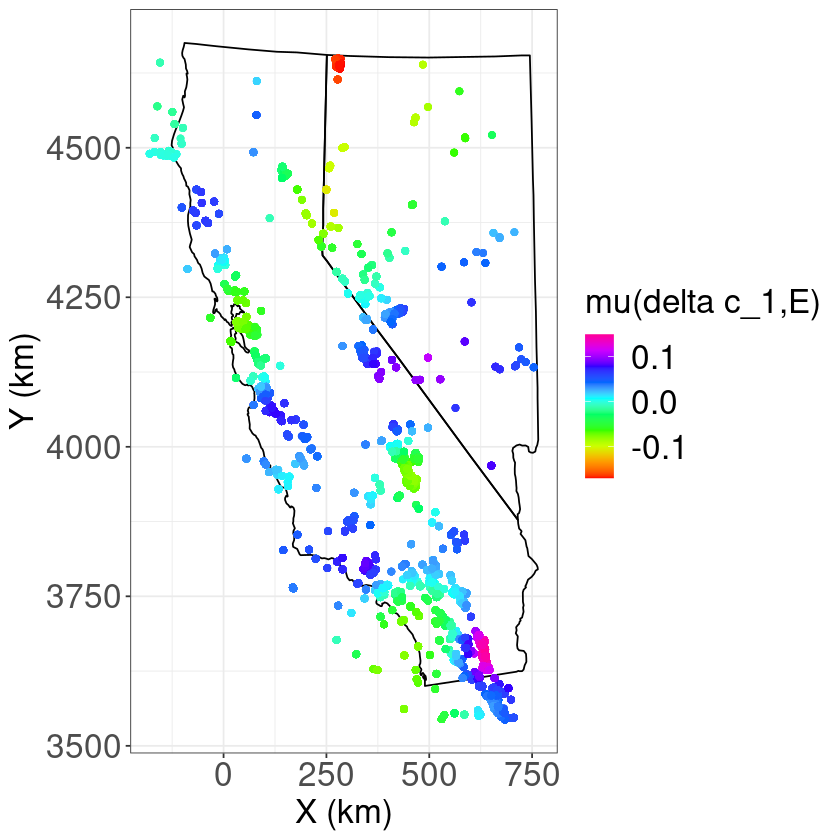

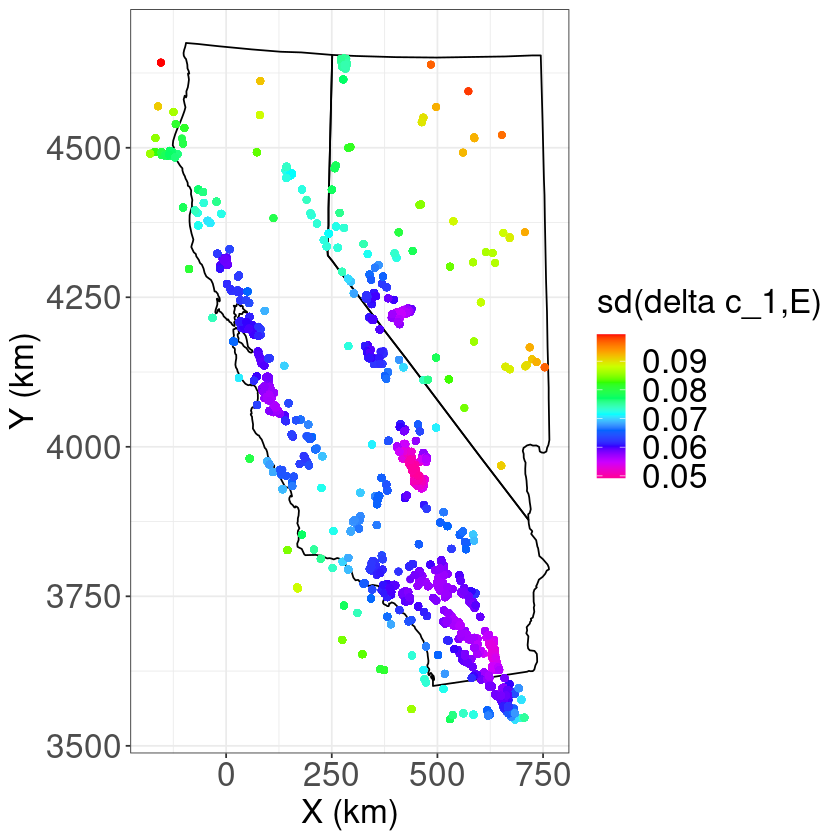

In [9]:
print(pl_dc1e_mu_map)
print(pl_dc1e_sd_map)

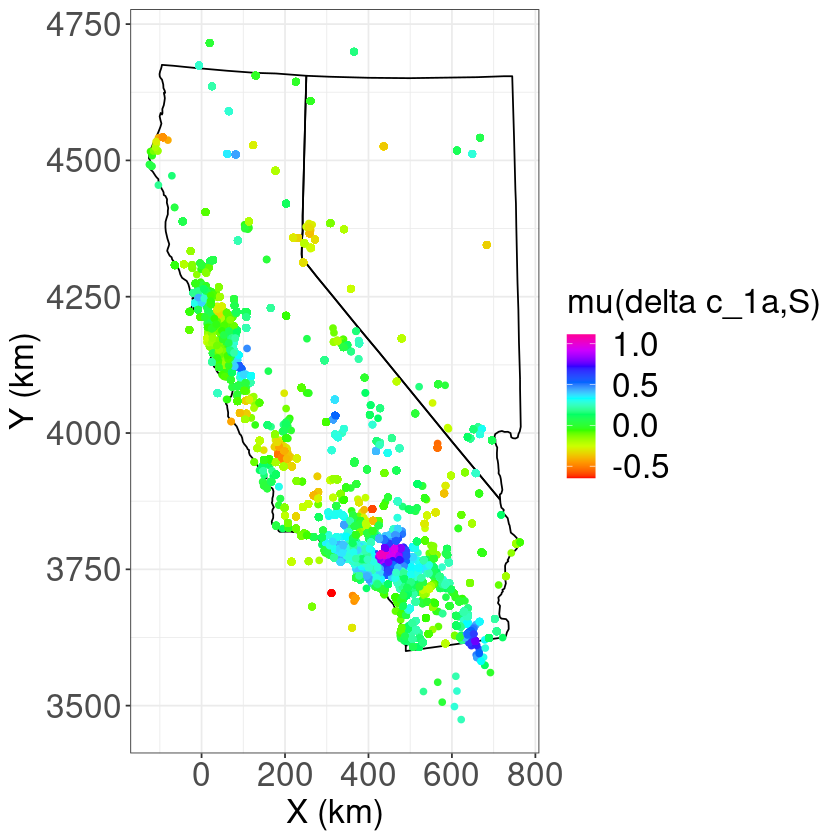

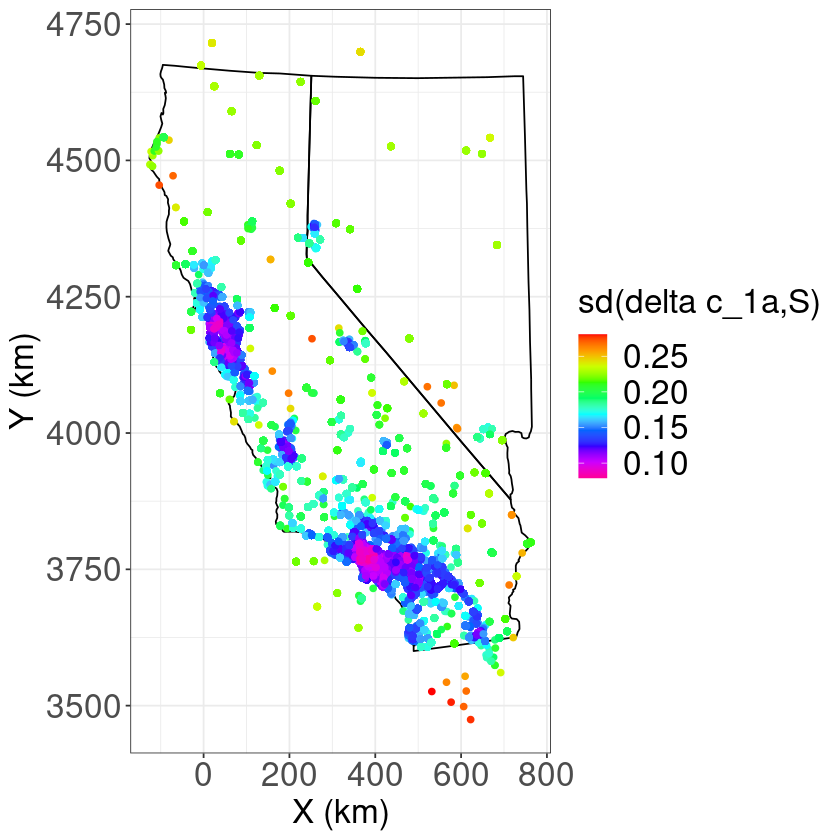

In [10]:
print(pl_dc1as_mu_map)
print(pl_dc1as_sd_map)

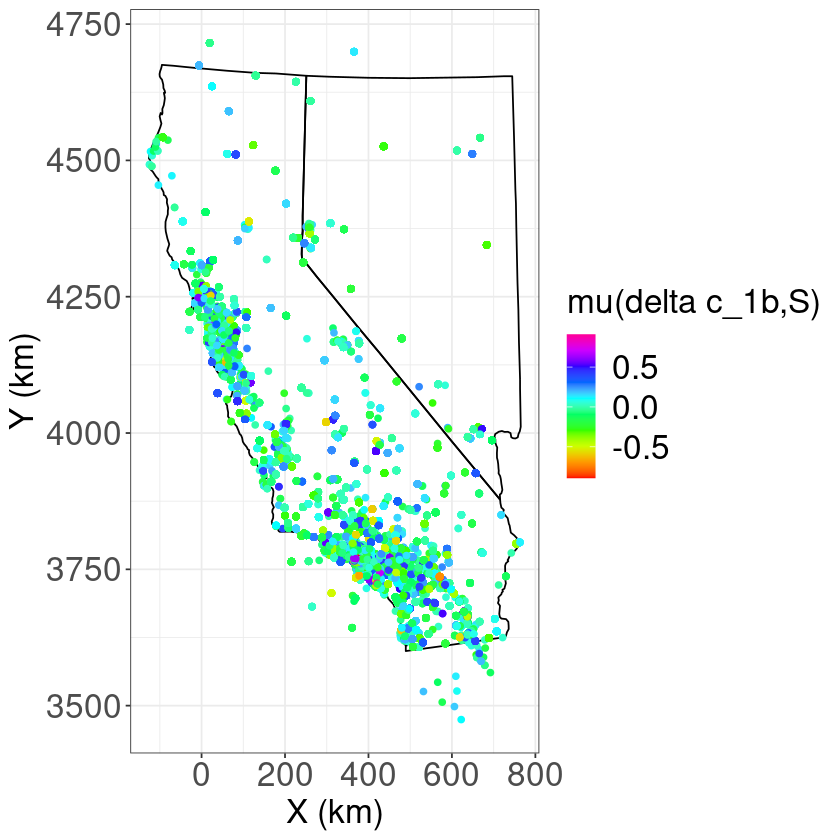

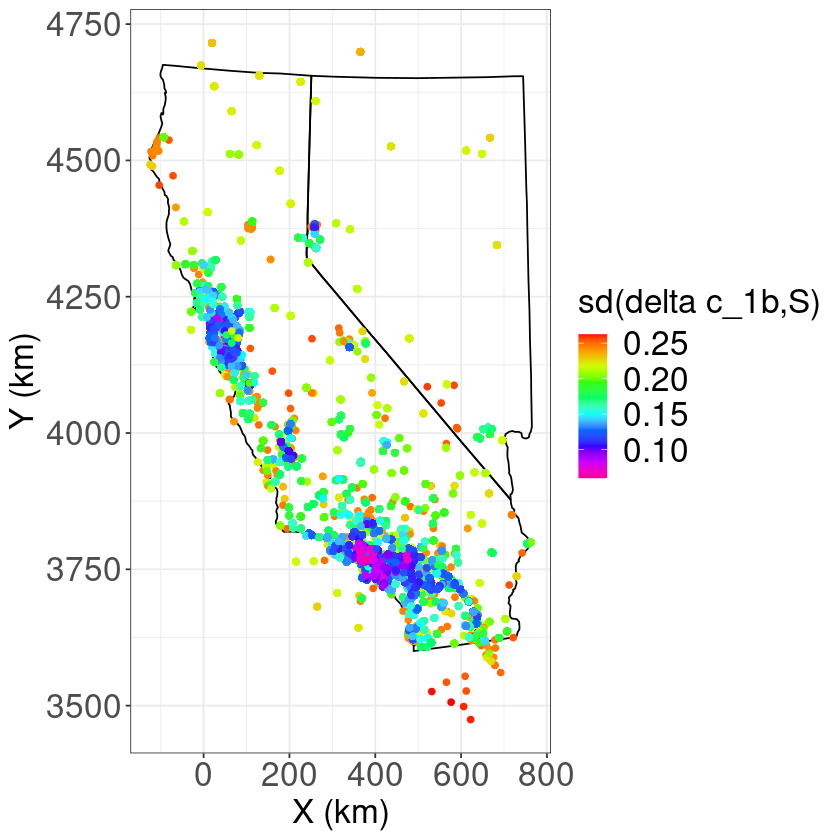

In [11]:
print(pl_dc1bs_mu_map)
print(pl_dc1bs_sd_map)

### Cell-specific Anelastic Attenuation

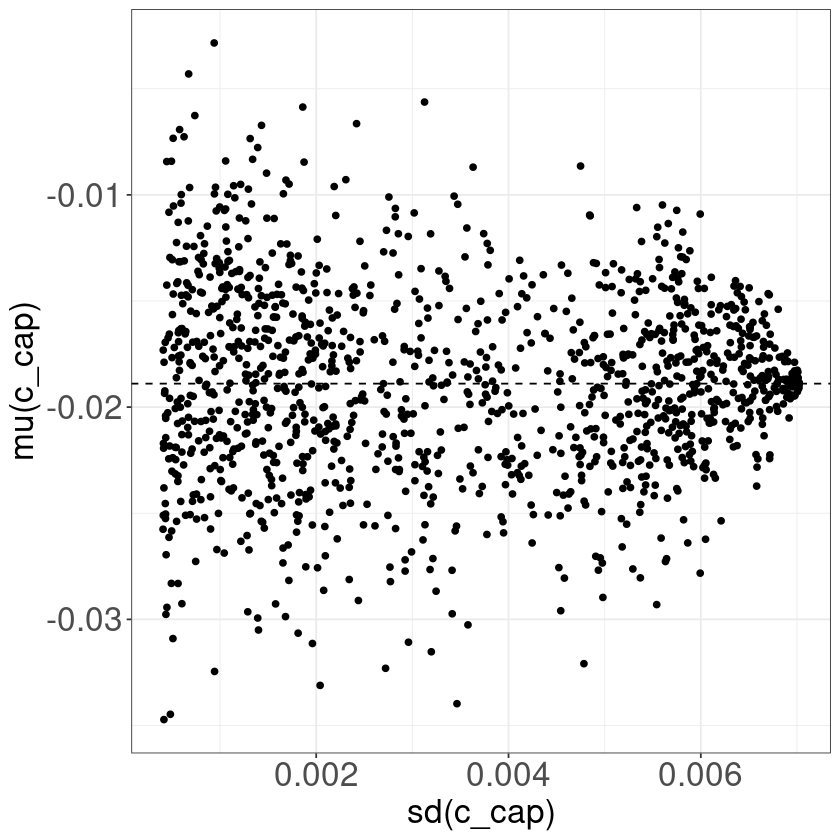

In [12]:
#cell-specific anelastic attenuation: mean versus std 
pl_c_cap <- ggplot(df_atten, aes(c_cap_sig, c_cap_mean)) + theme_bw() +
                geom_point() + geom_hline(yintercept=df_hparam['mean','mu_cap'],linetype="dashed") +
                labs(x='sd(c_cap)', y='mu(c_cap)') + 
                theme(axis.title = element_text(size=20), 
                      axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

print(pl_c_cap)

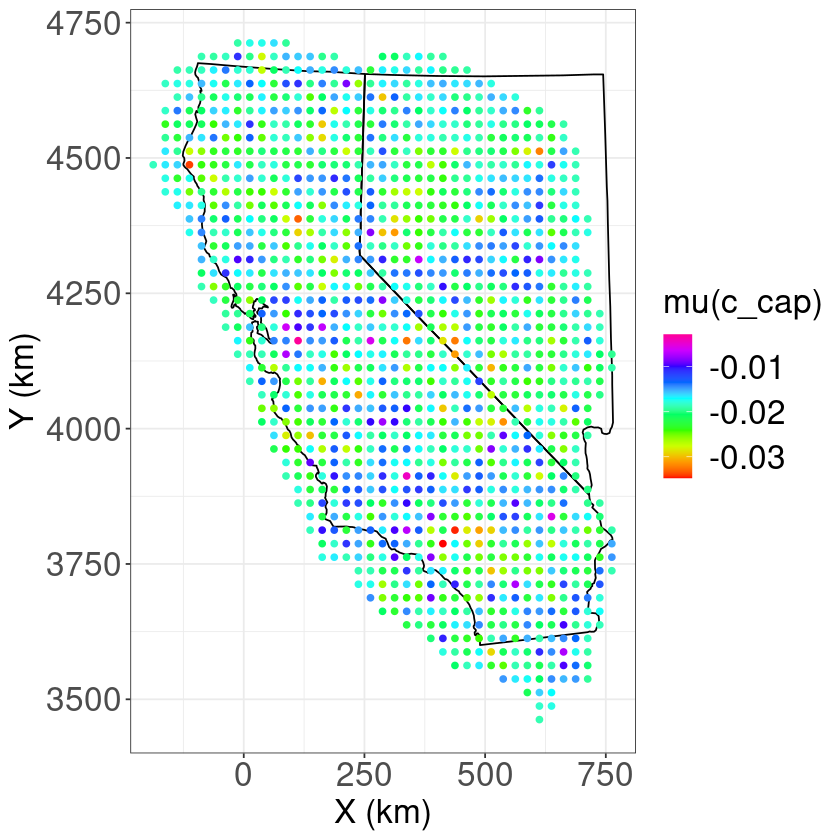

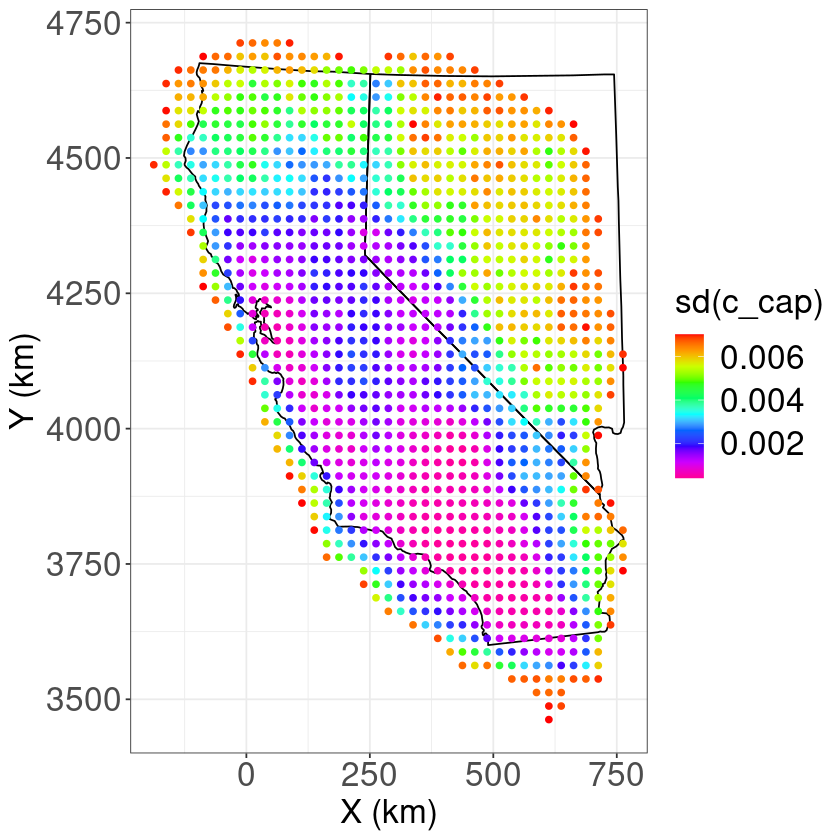

In [13]:
#cell-specific anelastic attenuation map
#mean
pl_c_cap_mu_map <- pl_map + geom_point(data=df_atten, aes(mptX, mptY, color=c_cap_mean)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='mu(c_cap)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))
#std
pl_c_cap_sd_map <- pl_map + geom_point(data=df_atten, aes(mptX, mptY, color=c_cap_sig)) +
                      scale_color_gradientn(colours = rev(rainbow(10))) +
                      labs(x='X (km)', y='Y (km)', color='sd(c_cap)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

print(pl_c_cap_mu_map)
print(pl_c_cap_sd_map)